In [1]:
from Invariant_Flow import *
from rover_planning import *
from SE2Lie import *
from tabulate import tabulate
import matplotlib.pyplot as plt

# Trajectory planning and control

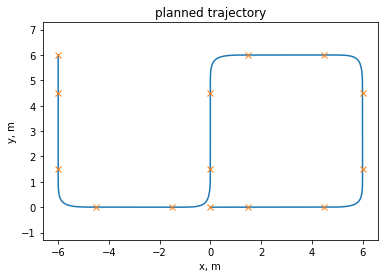

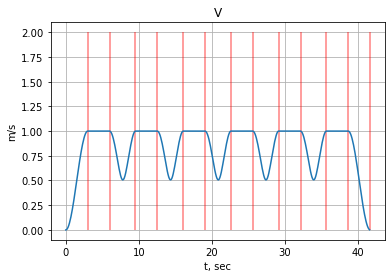

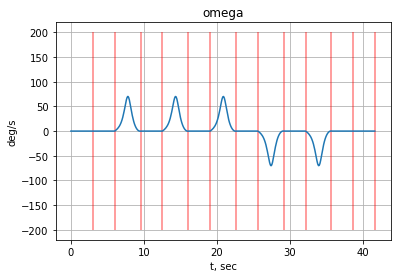

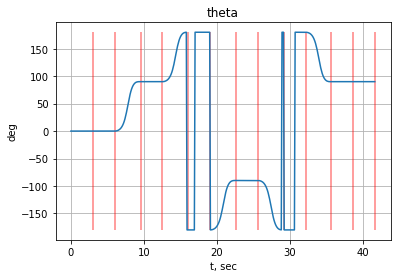

In [2]:
v  = 1
r = 1.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
planner.goto(6, 0, v, r)
planner.goto(6, 6, v, r)
planner.goto(0, 6, v, r)
planner.goto(0, 0, v, r)
planner.goto(-6, 0, v, r)
planner.goto(-6, 6, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
planner.stop(-6, 6)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]

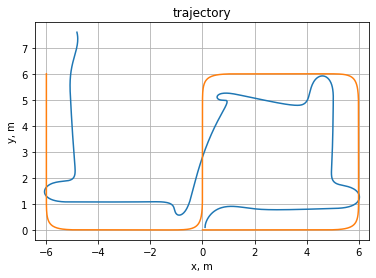

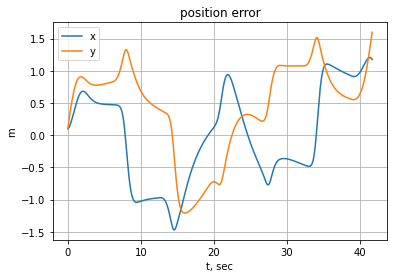

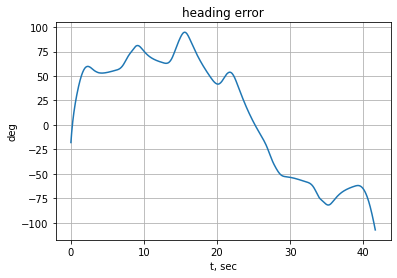

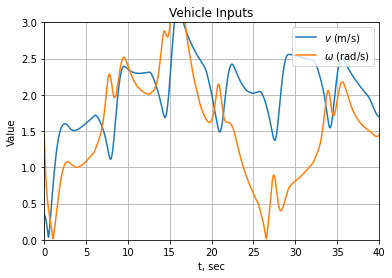

In [3]:
sol_s = find_se2_invariant_set() # u, v, w1, w2
# r = simulate_rover(planner, freq_d=.015, w1=.1, w2=.1, x0=0.1, y0=0.1, theta0=pi/10, dist='sine', sol=sol_s, dt=.05, use_approx=False)
r = simulate_rover(planner, freq_d=.0149, w1=1, w2=1, x0=0.1, y0=0.1, theta0=pi/10, dist='sine', sol=sol_s, dt=.05, use_approx=False)
plot_rover_sim(res=r, planner=planner)

# Invariant Set

In [4]:
sol = find_se2_invariant_set()
w1 = 1*svd(15*pi/20)
w2 = 1
e = array([0.1, 0.1,0]) # Lie Group
e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra

t = 10
points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra

inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

Text(0.5, 1.0, 'Invariant Set in Lie Group')

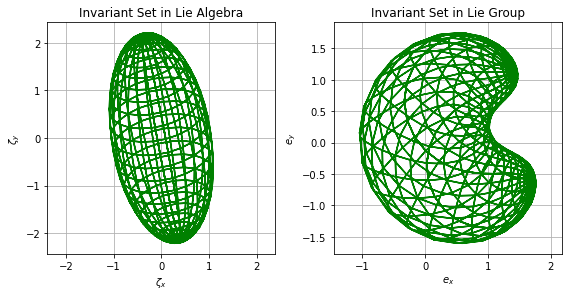

In [5]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(e0[0],e0[1],'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')

# plt.figure(figsize=(8,4))
# ax = plt.subplot(121)
# ax.plot(points[1, :], points[2, :], 'g')
# ax.set_xlabel('y')
# ax.set_ylabel('$\\theta$')
# plt.axis('equal')
# ax2 = plt.subplot(122)
# ax2.plot(exp_points[1, :], exp_points[2, :], 'g')
# ax2.set_xlabel('y')
# ax2.set_ylabel('$\\theta$')
# plt.axis('equal')
# plt.tight_layout()

# plt.figure(figsize=(8,4))
# ax = plt.subplot(121)
# ax.plot(points[0, :], points[2, :], 'g');
# ax.set_xlabel('x')
# ax.set_ylabel('$\\theta$')
# plt.axis('equal')
# ax2 = plt.subplot(122)
# ax2.plot(exp_points[0, :], exp_points[2, :], 'g');
# ax2.set_xlabel('x')
# ax2.set_ylabel('$\\theta$')
# plt.axis('equal')
# plt.tight_layout()

# plt.figure(figsize=(12,6))
# ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
# ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('$\\theta$')
# plt.axis('auto')
# ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
# ax2.plot3D(exp_points[0, :], exp_points[1, :], exp_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
# plt.axis('auto')
# plt.tight_layout()

1.946799113346866


Text(0.5, 1.0, 'Invariant Set from LMI')

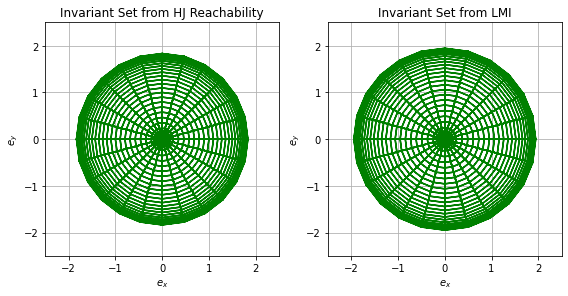

In [6]:
r=1.8351
hj_points = hj_invariant_set_points(r) 
dist = np.zeros((inv_points.shape[1]))
for i in range(inv_points.shape[1]):
    dist[i] = np.sqrt(inv_points[1,i]**2 + inv_points[0,i]**2)
LG_swe_points = hj_invariant_set_points(dist.max())
print(dist.max())

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(hj_points[0, :], hj_points[1, :], 'g');
ax.set_xlabel('$e_x$')
ax.set_ylabel('$e_y$')
#ax.plot(e0[0],e0[1],'ro')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(LG_swe_points[0, :-1], LG_swe_points[1, :-1], 'g');
#ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
ax2.set_xlim([-2.5,2.5])
ax2.set_ylim([-2.5,2.5])
plt.tight_layout()
ax.set_title('Invariant Set from HJ Reachability')
ax2.set_title('Invariant Set from LMI')

# Flow Pipes Simulation

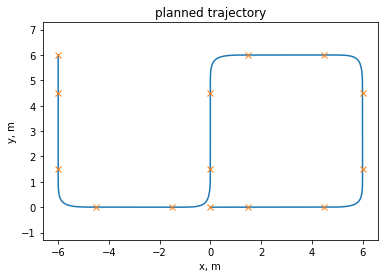

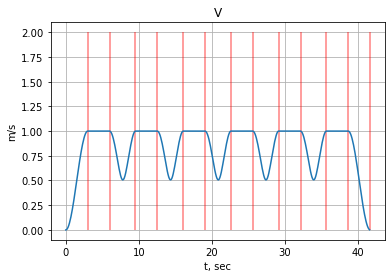

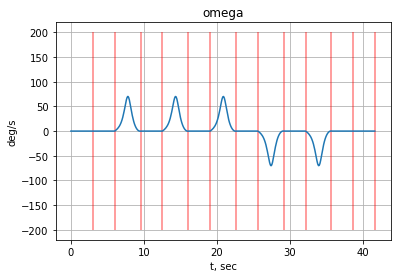

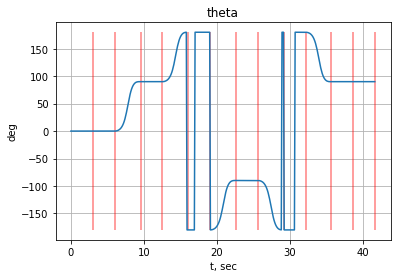

In [7]:
v  = 1
r = 1.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
planner.goto(6, 0, v, r)
planner.goto(6, 6, v, r)
planner.goto(0, 6, v, r)
planner.goto(0, 0, v, r)
planner.goto(-6, 0, v, r)
planner.goto(-6, 6, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
planner.stop(-6, 6)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]

In [8]:
n = 35# number of interval hulls
# disturbances
w1 = 1
w2 = 1
sol_s = find_se2_invariant_set() # u, v, w1, w2

e0 = SE2(.1, .1, 0).log.vee
x0 = np.array([0,0,0])

n, flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol_s)

Text(0, 0.5, 'y')

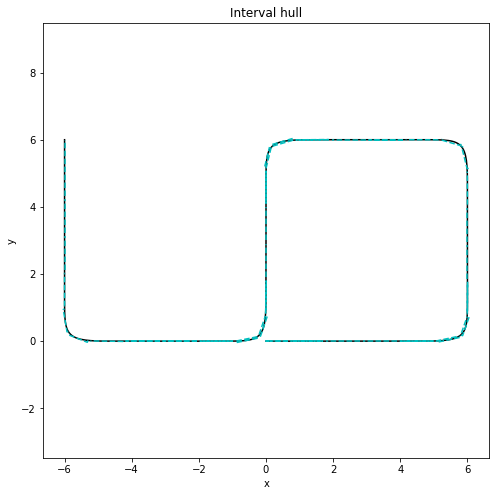

In [9]:
# interval hull
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')

plt.axis('equal')
title('Interval hull')
xlabel('x')
ylabel('y')

Text(0, 0.5, 'y')

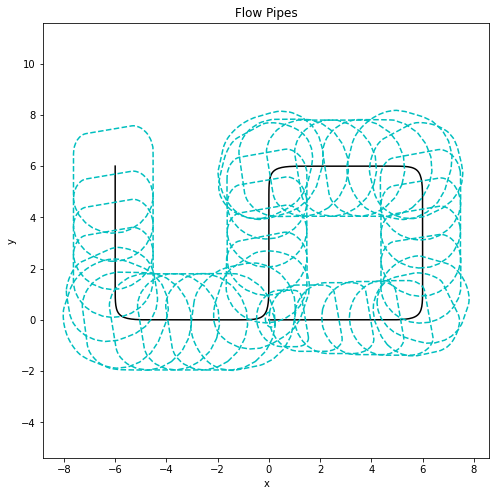

In [10]:
# flow pipes
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Flow Pipes')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

# Trajectories simulation with flow pipe

In [11]:
V2 = np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P2 = rot_mat5*Polytope(V2)
p4 = (5, 4)
P3 = P2*1.5 + (-2,5)
P4 = P2 + p4

P5 = 0.5*P3 - (2, 1)

[[ 0.1       ]
 [-0.1       ]
 [-0.03141593]]
[ 0.10156257 -0.09842098 -0.03141593]


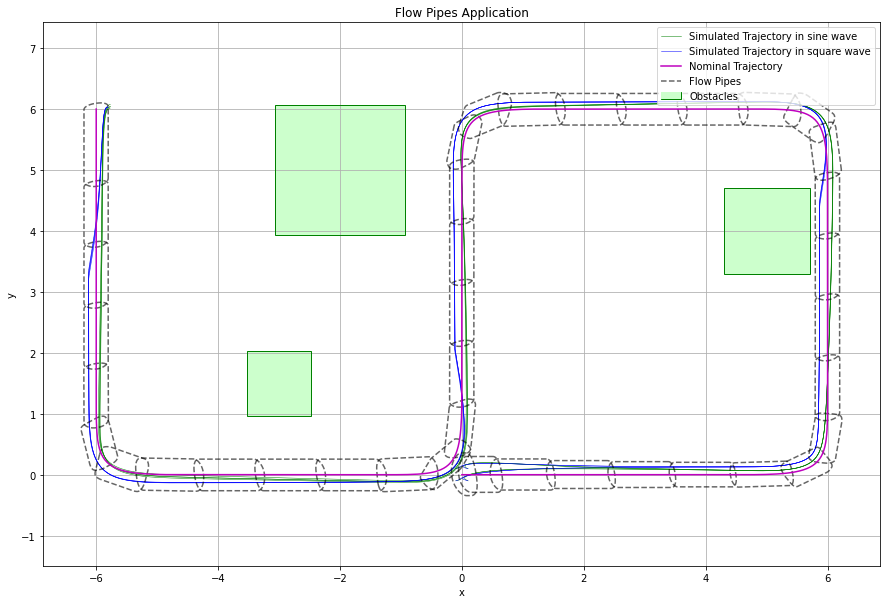

In [15]:
# small distrubance
freq = [0.04]#, 0.08, 0.025]#, .02]#, .03]#, .05]#, .05, .07, .09]
e = []
V = []
t = 40
n = 39 # number of interval hulls
# disturbances
w1 = .1
w2 = .1
sol_s = find_se2_invariant_set()

cnt = 0
for theta0 in np.arange(-pi/100, pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                r = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='sine', sol = sol_s, dt=1e-3, use_approx = False)
                r1 = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='square', sol = sol_s, dt=1e-3, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(r, name=' in sine wave', legend=legend, save=False, linewidth = .5, color = 'g')
                plot_rover_simulated(r1, name=' in square wave', legend=legend, save=False, linewidth = .5, color = 'b')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
n, flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol_s)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 0.1       ]
 [-0.1       ]
 [-0.03141593]]
[ 0.10156257 -0.09842098 -0.03141593]
0.0
0.0
0.0
0.0
0.0
0.0
0.005274880132367426
0.5614351145981912
1.5512182488381057
1.5710524107109805
1.5707963267948966
1.5707963267948966
1.5707963267948966
1.5729261897344542
2.04546890186152
3.110335263381398
3.141592653589793
3.141592653589793
3.141592653589793
3.141592653589793
3.141592653589793
3.128060558457806
2.4296804397793244
1.578617526916682
1.5707963267948966
1.5707963267948968
1.570796326794897
1.5708185481361105
1.9001834250546805
3.074080697844594
3.141592653589793
3.141592653589793
3.141592653589793
3.141592653589793
3.141592653589793
3.1378981249643205
2.6195040235800056
1.5950720736111084
1.5707963267948966
1.5707963267948966
1.5707963267948966
1.5707963267948966
1.5707963267948966
1.5707963267948966


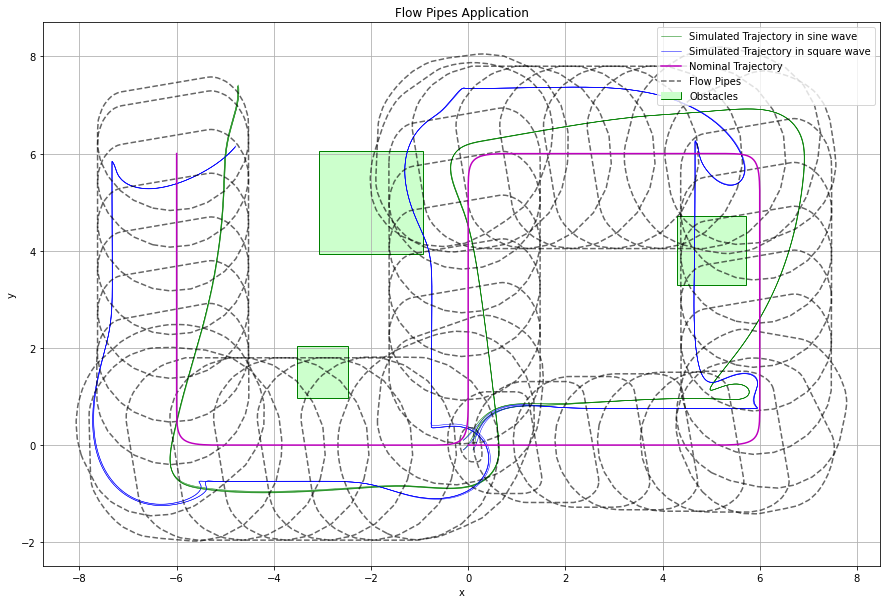

In [23]:
# small distrubance
freq = [0.04]#, 0.08, 0.025]#, .02]#, .03]#, .05]#, .05, .07, .09]
e = []
V = []
t = 40
n = 43 # number of interval hulls
# disturbances
w1 = 1
w2 = 1
sol_s = find_se2_invariant_set()

cnt = 0
for theta0 in np.arange(-pi/100, pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                r = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='sine', sol = sol_s, dt=1e-3, use_approx = False)
                r1 = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='square', sol = sol_s, dt=1e-3, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(r, name=' in sine wave', legend=legend, save=False, linewidth = .5, color = 'g')
                plot_rover_simulated(r1, name=' in square wave', legend=legend, save=False, linewidth = .5, color = 'b')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
n, flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol_s)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())